In [266]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score,plot_confusion_matrix


dir_data = './data/'

# Bereitgestellte Dateien
filename_train_values = 'train_values.csv'
filename_train_labels = 'train_labels.csv'
filename_prediction_values = 'test_values.csv'

# Erzeuge Dateinamen für gegebene Datein
filepath_train_values = os.path.join(dir_data, filename_train_values)
filepath_train_labels = os.path.join(dir_data, filename_train_labels)
filepath_prediction_values = os.path.join(dir_data, filename_prediction_values)

# Erzeugte Dateipfad für zu erzeugende Dateien
filename_prediction_labels = 'BILZ_MARKUS_prediction.csv'
filepath_prediction_labels = os.path.join(dir_data,filename_test_labels)

# Prüfungen auf Vorhandensein Daten
if not os.path.isdir(dir_data):
    raise FileNotFoundError("Data Verzeichnis fehlend.")
if not len(os.listdir(dir_data)):
    raise FileNotFoundError("Dateien fehlend.")

if not filepath_train_values:
    raise FileNotFoundError(f"{filename_train_values} fehlend.")
if not filepath_train_labels:
    raise FileNotFoundError(f"{filename_train_labels} fehlend.")
if not filepath_prediction_values:
    raise FileNotFoundError(f"{filename_prediction_values} fehlend.")

# Lade gegebene Daten
train_samples = pd.read_csv(filepath_train_values, sep='|')
train_labels = pd.read_csv(filepath_train_labels, sep='|')
prediction_samples = pd.read_csv(filepath_prediction_values, sep='|')


./data/train_values.csv


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


1. $tau[x]$: reaction time of participant (real from the range $[0.5,10]$s). Tau1 - the value for electricity producer.
2. $p[x]$: nominal power consumed(negative)/produced(positive)(real). For consumers from the range $[-0.5,-2]s^{-2}$; $p1 = |p2 + p3 + p4|$
3. $g[x]$: coefficient (gamma) proportional to price elasticity (real from the range $[0.05,1]s^{-1}$). g1 - the value for electricity producer.
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. stabf: the stability label of the system (categorical: stable/unstable)

(Quelle: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simul)

## Data understanding

In [ ]:
train_samples.head()

In [267]:
train_samples.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5.235266,5.263042,5.239916,5.269278,3.749237,-1.249405,-1.250982,-1.248849,0.525875,0.526143,0.524256,0.526372
std,2.748381,2.746766,2.736026,2.750045,0.756281,0.433926,0.434521,0.434267,0.274410,0.274565,0.275187,0.273592
min,0.500793,0.501582,0.500788,0.500473,1.582590,-1.999891,-1.999715,-1.999926,0.050009,0.050053,0.050054,0.050028
25%,2.855398,2.884650,2.860061,2.893386,3.212721,-1.627030,-1.629353,-1.625261,0.286748,0.285898,0.285277,0.291064
50%,5.217622,5.269852,5.253587,5.300431,3.746282,-1.250135,-1.250900,-1.245695,0.528247,0.527747,0.523578,0.526853
75%,7.608241,7.649058,7.611346,7.659247,4.285685,-0.872173,-0.869930,-0.872578,0.762899,0.764032,0.762756,0.762532
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500361,-0.500025,0.999937,0.999944,0.999839,0.999930


In [271]:
train_labels.head()

,target
0,unstable
1,stable
2,unstable
3,unstable
4,unstable


## Data Preparation

In [268]:
# Prüfe auf N/A
train_samples.isna().sum()

tau1    0
tau2    0
tau3    0
tau4    0
p1      0
p2      0
p3      0
p4      0
g1      0
g2      0
g3      0
g4      0
dtype: int64

In [269]:
# entferne samples ohne Vorhersagekraft
train_samples.drop(columns=['p1'])

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923
...,...,...,...,...,...,...,...,...,...,...,...
7995,3.114442,4.781072,2.427918,7.989509,-0.918191,-0.652736,-1.102228,0.867950,0.888858,0.460587,0.965026
7996,5.754191,3.032743,5.084803,4.633624,-1.717030,-1.713212,-1.769009,0.157284,0.975921,0.511555,0.696591
7997,2.042954,8.514335,8.173809,5.466635,-1.639912,-0.662469,-1.481417,0.154129,0.944486,0.053225,0.499109
7998,2.930406,9.487627,2.376523,6.187797,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385


In [270]:
# standardize_data
scaler = StandardScaler()
train_samples = scaler.fit_transform(train_samples)

display(train_samples)

array([[-0.82825072, -0.79485973,  1.14812721, ...,  1.21449145,
         1.3198757 ,  1.57785437],
       [ 1.48053903, -0.13126006, -0.80134931, ...,  1.22482107,
         0.13767332,  0.93351917],
       [ 1.35959106,  1.30539358, -0.80173748, ...,  0.87615481,
         1.14543438, -1.52250346],
       ...,
       [-1.16159736,  1.18375437,  1.07238617, ...,  1.52375607,
        -1.71178545, -0.09965713],
       [-0.83867705,  1.53811757, -1.04661716, ...,  0.92333598,
         1.0511926 ,  0.29977985],
       [-0.67060649, -1.45205838, -0.83519386, ...,  0.1496986 ,
        -0.86628773, -0.58577037]])

In [272]:
# Encodiere labels in 0 / 1 z. B. 0 = stable
label_encoder = preprocessing.LabelEncoder()
train_labels['target'] = label_encoder.fit_transform(train_labels['target'])
train_labels.head()

,target
0,1
1,0
2,1
3,1
4,1


In [273]:
# Aufteilen der Input-Daten in 70 % Trainings- und 30 % Testdaten
X_train, X_test, y_train, y_test = train_test_split(train_samples, train_labels, test_size=0.3, random_state=1) 

# display(X_train)
# display(y_train)

## Data Modeling

In [274]:
# einfaches Prognosemodell
grid_sim_baseline = DecisionTreeClassifier(random_state=1)
grid_sim_baseline.fit(X_train, y_train)

y_pred = grid_sim_baseline.predict(X_test)
# apply transformation
# y_pred = label_encoder.inverse_transform(y_pred)
# print(y_pred)

## Data Evaluation

accuracy 0.8420833333333333


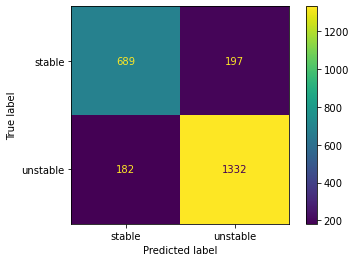

Matthews Corrcoeff 0.6598174076382205


In [275]:
print("accuracy", accuracy_score(y_test, y_pred))
# FIXME: https://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/

plot_confusion_matrix(grid_sim_baseline, X_test, y_test, display_labels=label_encoder.classes_)
plt.show()

# FIXME: Lese mehr darüber nach: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a
print("Matthews Corrcoeff", matthews_corrcoef(y_test, y_pred))

# Visualize decision tree

https://www.datacamp.com/community/tutorials/decision-tree-classification-python

https://programmerbackpack.com/decision-trees-classifier/